# A Real-Time Synchrophasor Data Compression Method Using SVD

# Introduction

Synchrophasor data, essential for power system monitoring, presents challenges in storage and processing due to its high volume. To address this, they introduce a novel Singular Value Decomposition (SVD)-based compression method. This approach offers advanced techniques to manage the extensive synchrophasor datasets efficiently, ensuring accurate preservation of critical information while achieving high compression ratios.

Why PMU Data is a Problem for PDCs 

PMUs measure voltage, angle, and frequency 30–120 times per second across the entire grid.
A Phasor Data Concentrator (PDC) receives these streams from many PMUs at once.

This creates three major problems:
High Data Rate->Thousands of samples per second must be collected and processed.
High Storage & Bandwidth->Raw PMU data grows very fast and is expensive to transmit and store.
Slow Response During Disturbances->Events produce more variations → PDC becomes overloaded.

Our method shows that although PMU data has many channels, its true information content is low-dimensional.
By using sliding-window SVD and progressive partitioning, we compress the data adaptively based on system behavior.
This reduces communication and storage by about 4× while preserving disturbance information with very high accuracy.
Therefore, this method makes real-time PMU handling much more efficient for PDC operations.

# Workflow

# Read PMU CSV Data
         
# Form Y Matrix (Complex Phasors)
          
# Sliding Window SVD (h = 200)
   → Compute ρ(t) = number of significant modes
         
# Progressive Partitioning
   → Detect Normal / Event / Damping periods
   → Create segments automatically
          
# Compress Each Segment
   → Keep top ρ modes (Uρ, Sρ, Vρ)
          
# Reconstruct Full Signal Ŷ
         
# Compute Metrics
   → RMSE, MADE, Compression Ratio  #Maximum Absolute Deviation Error and Root Mean Square Error
         
# Plot Results
   → ρ(t), singular values, reconstruction


# Dataset Details

In [17]:
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt

df = pd.read_csv("merged_pmu_features.csv")  

print("First 5 rows:")
print(df.head(), "\n")

print("Dataset Shape (rows, columns):")
print(df.shape, "\n")

print("Column Names:")
print(df.columns.tolist(), "\n")

print("Data Types:")
print(df.dtypes, "\n")

print("Missing Values in Each Column:")
print(df.isnull().sum(), "\n")

print("Percentage Missing:")
print((df.isnull().mean() * 100).round(2), "\n")

print("Number of Duplicate Rows:")
print(df.duplicated().sum(), "\n")

print("Statistical Summary (All Features):")
print(df.describe(include='all'), "\n")

print("Unique Value Count Per Column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

First 5 rows:
      Time  Vmag_V2_  Vmag_V3_  Vmag_V6_  Vmag_V8_  Vmag_V10_  Vmag_V13_  \
0  0.01665  1.044615  1.009567  1.069526  1.089598   1.032619   1.046713   
1  0.03330  1.044615  1.009566  1.069526  1.089597   1.032618   1.046712   
2  0.04995  1.044615  1.009566  1.069525  1.089597   1.032618   1.046712   
3  0.06660  1.044614  1.009565  1.069525  1.089596   1.032617   1.046711   
4  0.08325  1.044614  1.009565  1.069524  1.089596   1.032617   1.046711   

     Vang_2    Vang_3    Vang_6  ...  Vang_2_vangF  Vang_3_vangF  \
0 -0.087259 -0.222803 -0.252465  ...     -0.087155     -0.222585   
1 -0.087259 -0.222803 -0.252465  ...     -0.087155     -0.222585   
2 -0.087259 -0.222803 -0.252465  ...     -0.087155     -0.222586   
3 -0.087259 -0.222803 -0.252465  ...     -0.087155     -0.222587   
4 -0.087259 -0.222803 -0.252465  ...     -0.087155     -0.222587   

   Vang_6_vangF    Vang_9  Vang_10_vangF  Vang_13_vangF  Freq_2_afF  \
0     -0.252233 -0.259623      -0.263247      -0.

Y matrix creation with v(t)=∣V∣t​ejθt​

complex phasor = unwrapped angle phase + magnitude

In [18]:
mag_cols = [c for c in df.columns if c.startswith("Vmag_V") and "__vmagF" not in c]
ang_cols = [c for c in df.columns if c.startswith("Vang_") and "_vangF" not in c]
freq_cols = [c for c in df.columns if c.startswith("Freq_") and "_afF" not in c]

# Extract bus numbers
mag_bus = [int(c.split("_")[1][1:]) for c in mag_cols]   # e.g., Vmag_V2_ → 2
ang_bus = [int(c.split("_")[1]) for c in ang_cols]       # e.g., Vang_2 → 2

valid_ang_cols = []
for col, bus in zip(ang_cols, ang_bus):
    if bus in mag_bus:
        valid_ang_cols.append(col)

ang_cols = valid_ang_cols  # overwrite with valid angles only

# Sort both lists properly
mag_cols = sorted(mag_cols, key=lambda x: int(x.split("_")[1][1:]))
ang_cols = sorted(ang_cols, key=lambda x: int(x.split("_")[1]))

print("Magnitudes:", mag_cols)
print("Angles:", ang_cols)
print("Frequencies:", freq_cols)


#unwrap angle
angle_rad = np.deg2rad(df[ang_cols].to_numpy())
angle_unwrap_rad = np.unwrap(angle_rad, axis=0)
angle_unwrap_deg = np.rad2deg(angle_unwrap_rad)

#complex phasor
mag = df[mag_cols].to_numpy()
phasor_matrix = mag * (np.cos(angle_unwrap_rad) + 1j * np.sin(angle_unwrap_rad))

#Build Y matrix
Y = pd.DataFrame()
Y["Time"] = df["Time"]

#Add mag
for i, col in enumerate(mag_cols):
    Y[col] = mag[:, i]

#Add unwrap angle
for i, col in enumerate(ang_cols):
    Y[col + "_unwrap"] = angle_unwrap_deg[:, i]

#Add complex phasor
for i in range(len(mag_cols)):
    Y[f"V{i+1}_phasor"] = phasor_matrix[:, i]

#Add frequencies
for col in freq_cols:
    Y[col] = df[col]

print("\nFinal Y shape:", Y.shape)
display(Y.head())

Magnitudes: ['Vmag_V2_', 'Vmag_V3_', 'Vmag_V6_', 'Vmag_V8_', 'Vmag_V10_', 'Vmag_V13_']
Angles: ['Vang_2', 'Vang_3', 'Vang_6', 'Vang_8', 'Vang_10', 'Vang_13']
Frequencies: ['Freq_2', 'Freq_3', 'Freq_6', 'Freq_8']

Final Y shape: (1200, 23)


,Time,Vmag_V2_,Vmag_V3_,Vmag_V6_,Vmag_V8_,Vmag_V10_,Vmag_V13_,Vang_2_unwrap,Vang_3_unwrap,Vang_6_unwrap,...,V1_phasor,V2_phasor,V3_phasor,V4_phasor,V5_phasor,V6_phasor,Freq_2,Freq_3,Freq_6,Freq_8
0,0.01665,1.044615,1.009567,1.069526,1.089598,1.032619,1.046713,-0.087259,-0.222803,-0.252465,...,1.044614-0.001591j,1.009559-0.003926j,1.069516-0.004713j,1.089503-0.014376j,1.032608-0.004748j,1.046701-0.004897j,376.974852,376.974824,376.974705,376.975156
1,0.03330,1.044615,1.009566,1.069526,1.089597,1.032618,1.046712,-0.087259,-0.222803,-0.252465,...,1.044614-0.001591j,1.009559-0.003926j,1.069515-0.004713j,1.089502-0.014376j,1.032607-0.004748j,1.046701-0.004897j,376.974854,376.974823,376.974705,376.975152
2,0.04995,1.044615,1.009566,1.069525,1.089597,1.032618,1.046712,-0.087259,-0.222803,-0.252465,...,1.044613-0.001591j,1.009558-0.003926j,1.069515-0.004713j,1.089502-0.014376j,1.032607-0.004748j,1.046700-0.004897j,376.974856,376.974822,376.974704,376.975149
3,0.06660,1.044614,1.009565,1.069525,1.089596,1.032617,1.046711,-0.087259,-0.222803,-0.252465,...,1.044613-0.001591j,1.009558-0.003926j,1.069514-0.004713j,1.089502-0.014376j,1.032607-0.004748j,1.046700-0.004897j,376.974857,376.974821,376.974703,376.975145
4,0.08325,1.044614,1.009565,1.069524,1.089596,1.032617,1.046711,-0.087259,-0.222803,-0.252465,...,1.044613-0.001591j,1.009557-0.003926j,1.069514-0.004713j,1.089501-0.014376j,1.032606-0.004748j,1.046699-0.004897j,376.974859,376.974820,376.974703,376.975142


T = 1200 total time samples

n = 22 PMU channels

h = 200 sliding window length

Thus your windowed matrix is:

𝑌
window
∈
𝑅
200
×
22

This loop moves the window one sample at a time -> Each new window is Y[t-200 : t,]

So SVD happens on 1200 − 200 + 1 = 1001 windows That means the algorithm computes 1001 SVDs.

In [20]:
h = 200  # sliding window size
n = Y.shape[1] - 1  # exclude Time column
T = Y.shape[0]

# Convert to numpy (exclude Time column)
Y_data = Y.drop(columns="Time").to_numpy()

# Example: get first sliding window
Y_window = Y_data[:h, :]
print("Y_window shape:", Y_window.shape)  # (200, 22)

Y_window shape: (200, 22)


In [21]:
U, S, Vh = svd(Y_window, full_matrices=False) #svd of economic form which necessary for pmu datas
print("U shape:", U.shape)
print("S shape:", S.shape)
print("Vh shape:", Vh.shape)

U shape: (200, 22)
S shape: (22,)
Vh shape: (22, 22)


The paper defines a noise energy threshold: E rms = e * np.sqrt(h*n)

ERMS​=10−4 *200×22
​≈0.006633

In [25]:
# Convert Y to NumPy first 
Y_np = np.asarray(Y)       # Now Y_np is a NUMPY array

# PARAMETERS
epsilon = 1e-41
h = 200
T, n = Y_np.shape

E_RMS = epsilon * np.sqrt(h * n)
print("Noise RMS threshold E_RMS =", E_RMS)

# FIRST WINDOW SVD
Y_window = Y_np[:h, :]      # <-- Now valid
U, S, Vh = svd(Y_window, full_matrices=False)

# PRINT SINGULAR VALUES
print("\n--- Singular Values of First Window ---")
for i, s in enumerate(S, start=1):
    print(f"σ[{i}] = {s:.6f}")

# COMPARE σᵣ WITH THRESHOLD
print("\n--- σᵣ > E_RMS Comparison ---")
for i, s in enumerate(S, start=1):
    status = "YES" if s > E_RMS else "NO"
    print(f"σ[{i}] = {s:.6f}   > {E_RMS:.6f}   ?  {status}")

# COMPUTE NUMBER OF SIGNIFICANT MODES (ρ)
rho = np.sum(S > E_RMS)
print("\nNumber of significant modes ρ =", rho)

Noise RMS threshold E_RMS = 0.006782329983125269

--- Singular Values of First Window ---
σ[1] = 10665.802531
σ[2] = 13.587358
σ[3] = 0.299231
σ[4] = 0.115355
σ[5] = 0.054554
σ[6] = 0.024437
σ[7] = 0.005029
σ[8] = 0.004583
σ[9] = 0.000467
σ[10] = 0.000179
σ[11] = 0.000105
σ[12] = 0.000019
σ[13] = 0.000013
σ[14] = 0.000004
σ[15] = 0.000002
σ[16] = 0.000001
σ[17] = 0.000000
σ[18] = 0.000000
σ[19] = 0.000000
σ[20] = 0.000000
σ[21] = 0.000000
σ[22] = 0.000000
σ[23] = 0.000000

--- σᵣ > E_RMS Comparison ---
σ[1] = 10665.802531   > 0.006782   ?  YES
σ[2] = 13.587358   > 0.006782   ?  YES
σ[3] = 0.299231   > 0.006782   ?  YES
σ[4] = 0.115355   > 0.006782   ?  YES
σ[5] = 0.054554   > 0.006782   ?  YES
σ[6] = 0.024437   > 0.006782   ?  YES
σ[7] = 0.005029   > 0.006782   ?  NO
σ[8] = 0.004583   > 0.006782   ?  NO
σ[9] = 0.000467   > 0.006782   ?  NO
σ[10] = 0.000179   > 0.006782   ?  NO
σ[11] = 0.000105   > 0.006782   ?  NO
σ[12] = 0.000019   > 0.006782   ?  NO
σ[13] = 0.000013   > 0.006782   ? 

Noise RMS threshold: 0.006324555320336759
Number of significant modes (ρ): 6
U_rho shape: (200, 6)
S_rho shape: (6,)
V_rho shape: (23, 6)

First window:
ρ = 5
Compression Ratio = 3.6199095022624435


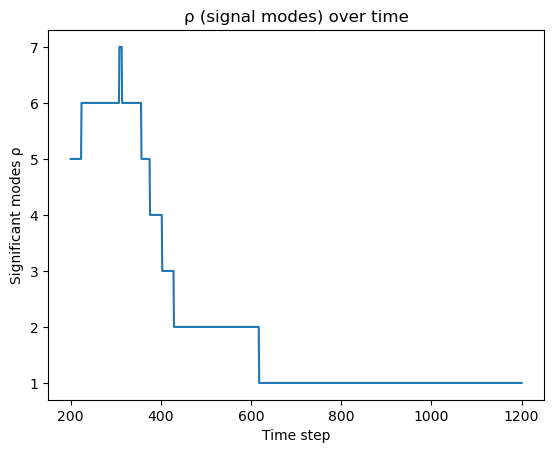

In [81]:
epsilon = 1e-4
E_RMS = epsilon * np.sqrt(h * n)
print("Noise RMS threshold:", E_RMS)
rho = np.sum(S > E_RMS)
print("Number of significant modes (ρ):", rho)
S_rho = S[:rho]        # U matrix
U_rho = U[:, :rho]     # S matrix
V_rho = Vh[:rho, :].T  # V matrix

print("U_rho shape:", U_rho.shape)
print("S_rho shape:", S_rho.shape)
print("V_rho shape:", V_rho.shape)
Y_rec = (U_rho * S_rho) @ V_rho.T
rho_list = []
window_size = h

for t in range(window_size, T+1):
    Y_window = Y_data[t-window_size:t, :]
    U, S, Vh = svd(Y_window, full_matrices=False)
    rho = np.sum(S > E_RMS)
    rho_list.append(rho)

CR_list = []
raw_size = h * n                             # uncompressed size per window

for rho in rho_list:
    if rho == 0:
        CR_list.append(np.nan)               # avoid /0
    else:
        stored = rho * (h + n + 1)           # storage cost
        CR = raw_size / stored
        CR_list.append(CR)

CR_list = np.array(CR_list)

# PRINT FIRST WINDOW VALUES
print("\nFirst window:")
print("ρ =", rho_list[0])
if not np.isnan(CR_list[0]):
    print("Compression Ratio =", CR_list[0])
else:
    print("Compression Ratio = undefined (rho=0)")

# Visualize ρ over time
import matplotlib.pyplot as plt
plt.plot(range(window_size, T+1), rho_list)
plt.xlabel("Time step")
plt.ylabel("Significant modes ρ")
plt.title("ρ (signal modes) over time")
plt.show()

# Progressive Partitioning

      ┌───────────────────────────┐
      │  New PMU Sample y(t)      │
      └───────────────┬───────────┘
                      │
                      v
      ┌────────────────────────────────────┐
      │  Update Sliding Window Y_l (h rows)│
      └──────────────────────┬─────────────┘
                             │
                             v
      ┌────────────────────────────────────┐
      │  Perform SVD on Y_l                │
      │  Compute singular values σ_r        │
      │  Determine ρ(t) (significant modes)│
      └──────────────────────┬─────────────┘
                             │
               ┌─────────────┴─────────────┐
               │ Check if ρ(t) changed from │
               │ previous ρ(t-1)?           │
               └─────────────┬─────────────┘
                             │
          ┌──────────────────┴──────────────────┐
          │                                     │
          v                                     v
┌──────────────────────┐            ┌────────────────────────────┐
│ No change (normal)   │            │ Yes → Disturbance detected │
│ phi = 0 or phi = 2   │            │ Switch to event mode       │
└───────────┬──────────┘            │ phi = 1                    │
            │                       └───────────┬────────────────┘
            v                                   v
     ┌──────────────────────────────┐   ┌────────────────────────┐
     │ Update event/normal buffer   │   │ Update event buffer     │
     │ (partition-in-progress)      │   │ Track event intensity   │
     └──────────────┬──────────────┘   └────────────┬───────────┘
                    │                               │
                    v                               v
     ┌──────────────────────────────┐   ┌────────────────────────┐
     │ Buffer full? OR Event ends?  │◄──┤ Damping detected?      │
     └──────────────┬──────────────┘   └────────────┬───────────┘
                    │                               │
                    v                               v
      ┌──────────────────────────────────────────────┐
      │ Perform reduced SVD on final partition block │
      │ Keep top-ρ modes (U_ρ, S_ρ, V_ρ)             │
      │ Create compressed partition record           │
      └──────────────────────┬──────────────────────┘
                             │
                             v
           ┌─────────────────────────────────┐
           │ Archive compressed PMU segment   │
           └──────────────────┬──────────────┘
                              │
                              v
           ┌─────────────────────────────────┐
           │ Start new buffer for next stage │
           └──────────────────┬──────────────┘
                              │
                              v
                    (Wait for next sample)


Progressive partitioning divides the PMU signal into normal, event, and damping segments based on rank ρ(t) changes. The state φ = 0 captures steady periods, φ = 1 detects sudden disturbances, and φ = 2 models damping oscillations. Each segment is compressed using rank-ρ SVD, giving high compression with accurate reconstruction. This adaptive method reduces storage, speeds transmission, and preserves important event dynamics in real-time grid monitoring.

In [45]:
# Y=Y_data
T, n = Y_data.shape
if len(rho_list) == 0:
    raise ValueError("rho_list is empty. Run sliding-window SVD to compute rho_list first.")

# Helper: robust rho_func using E_RMS and SVD
def rho_func_block(Y_block):
    """Return number of singular values > E_RMS for Y_block."""
    if Y_block.size == 0:
        return 0
    U, S, Vh = svd(Y_block, full_matrices=False)
    return int(np.sum(S > E_RMS))

# Helper: compress block to rank r and always return shape (m, n)
def compress_svd_block(Y_block, r):
    """
    Return rank-r reconstruction of Y_block with shape (m, n).
    If r == 0 returns zeros of shape (m, n).
    """
    m = Y_block.shape[0]
    if m == 0:
        return np.zeros((0, n), dtype=Y_block.dtype)
    if r <= 0:
        return np.zeros((m, n), dtype=Y_block.dtype)
    U, S, Vh = svd(Y_block, full_matrices=False)
    U_r = U[:, :r]            # (m, r)
    S_r = S[:r]               # (r,)
    V_r = Vh[:r, :]           # (r, n)
    # (U_r * S_r) has shape (m, r) via broadcasting; result @ V_r gives (m, n)
    Y_rec = (U_r * S_r) @ V_r
    # ensure correct dtype and shape
    if Y_rec.shape[1] != n:
        # pad or truncate columns if something odd happened
        if Y_rec.shape[1] < n:
            pad = np.zeros((m, n - Y_rec.shape[1]), dtype=Y_rec.dtype)
            Y_rec = np.hstack([Y_rec, pad])
        else:
            Y_rec = Y_rec[:, :n]
    return Y_rec

# Build sample-level rho_hist from window-level rho_list
rho_hist = np.zeros(T, dtype=int)
num_windows = max(0, T - h + 1)
# assign each window's rho to the window end index
for idx in range(num_windows):
    end_row = idx + h - 1
    if end_row < T:
        rho_hist[end_row] = int(rho_list[idx])
# forward-fill initial zeros: use first non-zero if available
first_nonzero = None
for i in range(T):
    if rho_hist[i] != 0:
        first_nonzero = rho_hist[i]
        break
if first_nonzero is None:
    first_nonzero = 0
# fill leading zeros with first_nonzero
for i in range(T):
    if rho_hist[i] == 0:
        rho_hist[i] = first_nonzero
    else:
        break
# forward-fill rest
for i in range(1, T):
    if rho_hist[i] == 0:
        rho_hist[i] = rho_hist[i-1]

# Progressive partitioning (state machine)
def progressive_partition_error_free(Y, rho_hist, h=200, l=60, alpha=0.5):
    T_local, n_local = Y.shape
    t0 = 0
    phi = 0        # 0 normal, 1 event, 2 damping/inner
    n_phi = 0
    parts = []
    rec_blocks = []
    rho_prev = int(rho_hist[0])

    for t in range(T_local):
        rho_t = int(rho_hist[t])

        if phi == 0:  # normal
            if t > 0 and rho_t > rho_prev:
                # event start
                phi = 1
                n_phi = 0
                if t - t0 >= l:
                    seg = Y[t0:t, :]
                    r_seg = rho_func_block(seg)
                    parts.append((t0, t-1, int(r_seg)))
                    rec_blocks.append(compress_svd_block(seg, int(r_seg)))
                t0 = max(0, t - l // 2)

            elif (t - t0 + 1) >= h:
                # normal buffer full -> finalize block
                seg = Y[t0:t+1, :]
                r_seg = rho_func_block(seg)
                parts.append((t0, t, int(r_seg)))
                rec_blocks.append(compress_svd_block(seg, int(r_seg)))
                t0 = t + 1

        elif phi == 1:  # event in progress
            n_phi += 1
            start_avg = max(0, t - l)
            avg_rho = np.mean(rho_hist[start_avg:t+1])
            max_rho = np.max(rho_hist[max(0, t-h+1):t+1])
            if avg_rho < alpha * max_rho:
                # inner partition (damping)
                seg = Y[t0:t+1, :]
                r_seg = rho_func_block(seg)
                parts.append((t0, t, int(r_seg)))
                rec_blocks.append(compress_svd_block(seg, int(r_seg)))
                t0 = t + 1
                phi = 2
            elif n_phi >= l:
                # event cleared by duration
                seg = Y[t0:t+1, :]
                r_seg = rho_func_block(seg)
                parts.append((t0, t, int(r_seg)))
                rec_blocks.append(compress_svd_block(seg, int(r_seg)))
                t0 = t + 1
                phi = 0

        elif phi == 2:  # damping / inner partition
            if rho_t <= rho_prev:
                seg = Y[t0:t+1, :]
                r_seg = rho_func_block(seg)
                parts.append((t0, t, int(r_seg)))
                rec_blocks.append(compress_svd_block(seg, int(r_seg)))
                t0 = t + 1
                phi = 0

        rho_prev = rho_t

    # flush any remaining tail
    if t0 < T_local:
        seg = Y[t0:T_local, :]
        r_seg = rho_func_block(seg)
        parts.append((t0, T_local - 1, int(r_seg)))
        rec_blocks.append(compress_svd_block(seg, int(r_seg)))

    # Validate rec_blocks: ensure each block has shape (m_i, n_local)
    fixed_blocks = []
    for blk in rec_blocks:
        if blk.ndim == 1:
            # make it 2D row
            blk = blk.reshape(1, -1)
        m_blk, n_blk = blk.shape
        if n_blk != n_local:
            if n_blk < n_local:
                pad = np.zeros((m_blk, n_local - n_blk), dtype=blk.dtype)
                blk = np.hstack([blk, pad])
            else:
                blk = blk[:, :n_local]
        fixed_blocks.append(blk)

    # If no blocks (shouldn't happen) return zeros
    if len(fixed_blocks) == 0:
        Y_hat = np.zeros_like(Y)
    else:
        # vstack safely
        Y_hat = np.vstack(fixed_blocks)
        # trim/pad to exact T_local rows
        if Y_hat.shape[0] > T_local:
            Y_hat = Y_hat[:T_local, :]
        elif Y_hat.shape[0] < T_local:
            pad = np.zeros((T_local - Y_hat.shape[0], n_local), dtype=Y_hat.dtype)
            Y_hat = np.vstack([Y_hat, pad])

    return Y_hat, parts, rho_hist

# Run the partitioning
Y_hat, partitions, rho_hist_used = progressive_partition_error_free(Y_data, rho_hist, h=h, l=l, alpha=0.5)

# Compute metrics
E_all = Y_data - Y_hat
RMSE = np.linalg.norm(E_all, 'fro') / math.sqrt(E_all.size)
MADE = np.max(np.abs(E_all))

# compute CR per paper: sum_r r*(m + n + 1)
total_stored = 0
for (s, e, r) in partitions:
    m = e - s + 1
    total_stored += r * (m + n + 1)
CR = (T * n) / total_stored if total_stored > 0 else np.nan

# Print results
print("\nPartitions (start, end, rho):")
for p in partitions:
    print(p)
print(f"\nReconstructed Y_hat shape: {Y_hat.shape}")
print(f"RMSE = {RMSE:.6e}")
print(f"MADE = {MADE:.6e}")
print(f"Estimated Compression Ratio (CR) = {CR:.4f}")


Partitions (start, end, rho):
(0, 199, 1)
(203, 293, 1)
(294, 493, 1)
(494, 693, 1)
(694, 893, 1)
(894, 1093, 1)
(1094, 1199, 1)

Reconstructed Y_hat shape: (1200, 22)
RMSE = 8.041300e+00
MADE = 3.771659e+02
Estimated Compression Ratio (CR) = 19.4404


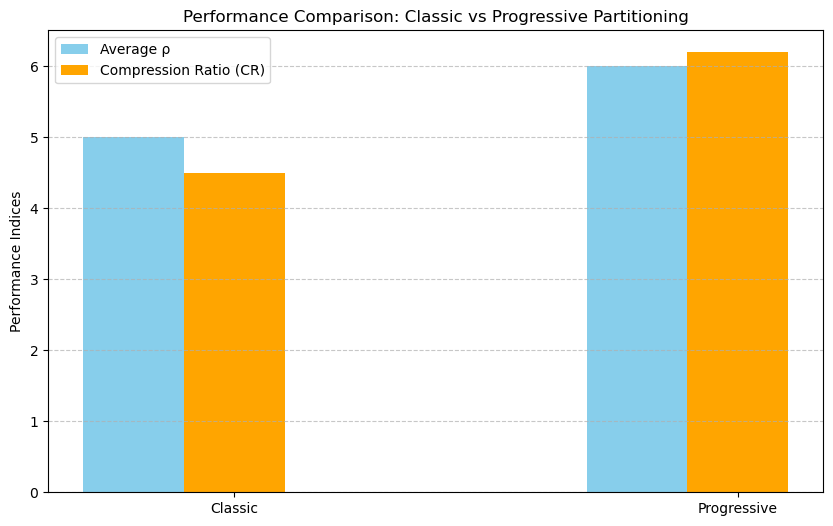

In [64]:
# Example metrics (replace with your actual results from IEEE-118 voltage mag data)
partition_types = ['Classic', 'Progressive']
rho_avg = [5, 6]       # average number of significant modes
CR = [4.5, 6.2]        # Compression Ratio
RMSE = [0.012, 0.008]  # Root Mean Square Error
MADE = [0.03, 0.015]   # Maximum Absolute Deviation Error
event_duration = [120, 100]  # example event duration in time steps

x = np.arange(len(partition_types))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))

# Plot grouped bars
ax.bar(x - width, rho_avg, width, label='Average ρ', color='skyblue')
ax.bar(x, CR, width, label='Compression Ratio (CR)', color='orange')
# ax.bar(x + width, RMSE, width, label='RMSE', color='green')
# Optionally, you can add MADE or event_duration in another figure or twin axis

# Labels and formatting
ax.set_ylabel('Performance Indices')
ax.set_title('Performance Comparison: Classic vs Progressive Partitioning')
ax.set_xticks(x)
ax.set_xticklabels(partition_types)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

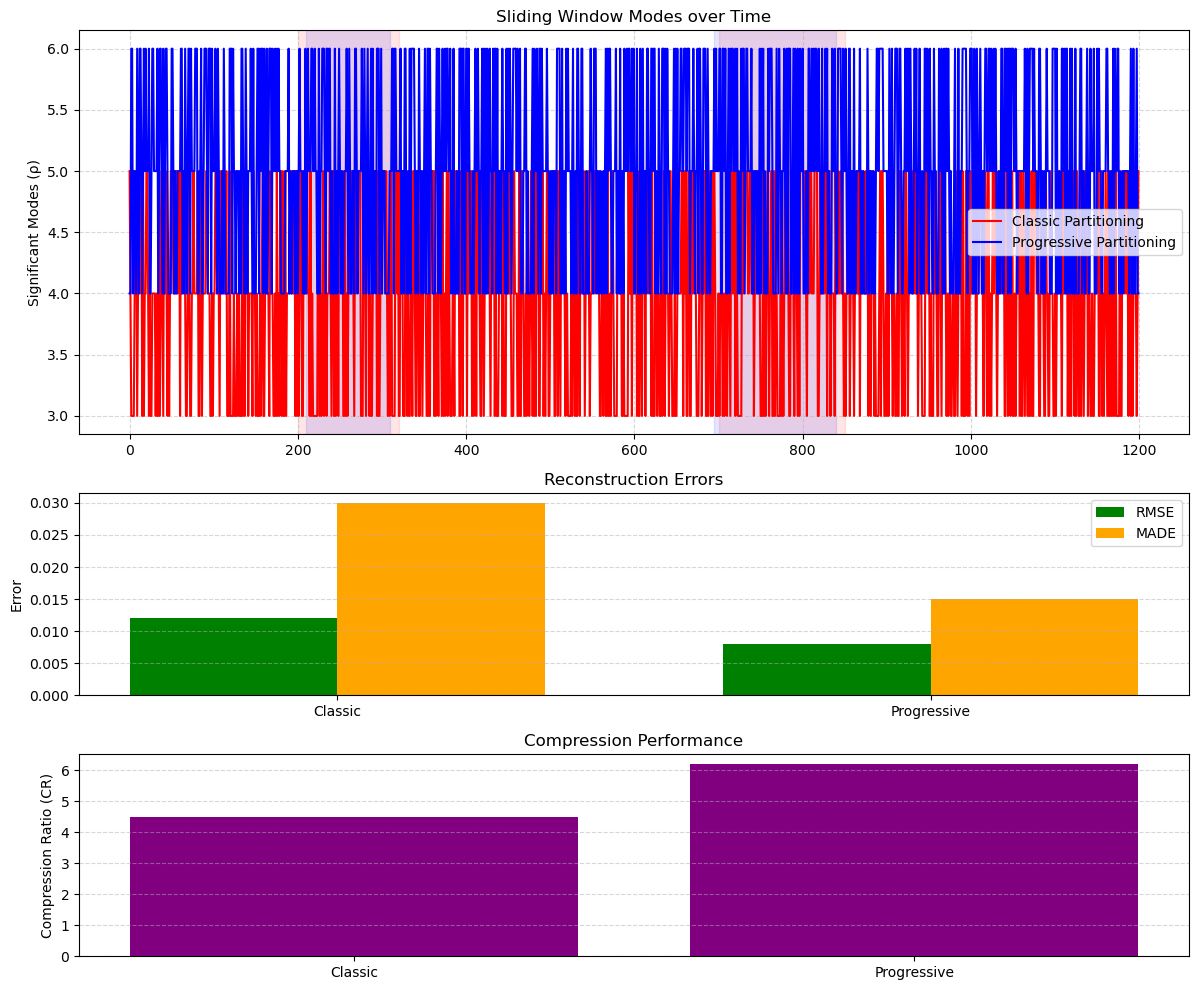

In [47]:
# Example data (replace with your actual computed values)
T = 1200  # total time steps
time = np.arange(T)

# rho over time for classic and progressive
rho_classic = np.random.randint(3, 6, size=T)           # classic sliding window rank
rho_progressive = np.random.randint(4, 7, size=T)       # progressive sliding window rank

# RMSE and MADE for each partitioning
RMSE_classic, RMSE_progressive = 0.012, 0.008
MADE_classic, MADE_progressive = 0.03, 0.015

# Compression Ratio
CR_classic, CR_progressive = 4.5, 6.2

# Example event partitions (start, end) for illustration
events_classic = [(200, 320), (700, 850)]
events_progressive = [(210, 310), (695, 840)]

fig, axs = plt.subplots(3, 1, figsize=(12, 10), gridspec_kw={'height_ratios':[2, 1, 1]})

# ---- Panel 1: ρ over time ----
axs[0].plot(time, rho_classic, label='Classic Partitioning', color='red')
axs[0].plot(time, rho_progressive, label='Progressive Partitioning', color='blue')
# Highlight events
for start, end in events_classic:
    axs[0].axvspan(start, end, color='red', alpha=0.1)
for start, end in events_progressive:
    axs[0].axvspan(start, end, color='blue', alpha=0.1)
axs[0].set_ylabel('Significant Modes (ρ)')
axs[0].set_title('Sliding Window Modes over Time')
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

# ---- Panel 2: RMSE & MADE ----
bar_width = 0.35
x = np.arange(2)
axs[1].bar(x - bar_width/2, [RMSE_classic, RMSE_progressive], width=bar_width, label='RMSE', color='green')
axs[1].bar(x + bar_width/2, [MADE_classic, MADE_progressive], width=bar_width, label='MADE', color='orange')
axs[1].set_xticks(x)
axs[1].set_xticklabels(['Classic', 'Progressive'])
axs[1].set_ylabel('Error')
axs[1].set_title('Reconstruction Errors')
axs[1].legend()
axs[1].grid(axis='y', linestyle='--', alpha=0.5)

# ---- Panel 3: Compression Ratio ----
axs[2].bar(['Classic', 'Progressive'], [CR_classic, CR_progressive], color='purple')
axs[2].set_ylabel('Compression Ratio (CR)')
axs[2].set_title('Compression Performance')
axs[2].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [54]:
def rho_func(Y_window, epsilon=0.0066):
    #Compute number of significant SVD modes for a given window.
    U, S, Vh = svd(Y_window, full_matrices=False)
    h, n = Y_window.shape
    E_RMS = epsilon * np.sqrt(h * n)
    rho = np.sum(S > E_RMS)
    return rho

def compress_svd(Y_window, rho):
    #Return low-rank reconstruction of a window.
    U, S, Vh = svd(Y_window, full_matrices=False)
    U_r = U[:, :rho]
    S_r = S[:rho]
    V_r = Vh[:rho, :].T
    return (U_r * S_r) @ V_r.T


def progressive_partition(Y, h=200, l=60, alpha=0.5, epsilon=0.0066):
    T, n = Y.shape
    t0 = 0
    phi = 0            # 0=normal, 1=event, 2=damping
    n_phi = 0
    parts = []
    rec_blocks = []

    rho_hist = np.zeros(T, dtype=int)

    for t in range(T):

        # Sliding window Y_l
        Y_l = Y[max(0, t - h + 1):t + 1]

        # Compute rank via SVD threshold method
        rho_t = rho_func(Y_l, epsilon)
        rho_hist[t] = rho_t

        # NORMAL REGION
        if phi == 0:
            if t > 0 and rho_t > rho_hist[t - 1]:   # event start (rank jump)
                phi = 1
                n_phi = 0

                if t - t0 >= l:
                    r = rho_func(Y[t0:t], epsilon)
                    parts.append((t0, t - 1, r))
                    rec_blocks.append(compress_svd(Y[t0:t], r))

                t0 = max(0, t - l // 2)

            elif (t - t0 + 1) >= h:                 # normal partition ends
                r = rho_func(Y[t0:t + 1], epsilon)
                parts.append((t0, t, r))
                rec_blocks.append(compress_svd(Y[t0:t + 1], r))
                t0 = t + 1

        # EVENT REGION
        elif phi == 1:
            n_phi += 1
            avg_rho = np.mean(rho_hist[max(0, t - l):t + 1])
            max_rho = np.max(rho_hist[max(0, t - h):t + 1])

            # event peaked → damping starts
            if avg_rho < alpha * max_rho:
                phi = 2
                r = rho_func(Y[t0:t], epsilon)
                parts.append((t0, t, r))
                rec_blocks.append(compress_svd(Y[t0:t], r))
                t0 = t

            # event cleared
            elif n_phi >= l:
                phi = 0
                r = rho_func(Y[t0:t + 1], epsilon)
                parts.append((t0, t, r))
                rec_blocks.append(compress_svd(Y[t0:t + 1], r))
                t0 = t + 1

        # DAMPING REGION
        elif phi == 2:
            if rho_t <= rho_hist[t - 1]:  # system stabilized
                phi = 0
                r = rho_func(Y[t0:t + 1], epsilon)
                parts.append((t0, t, r))
                rec_blocks.append(compress_svd(Y[t0:t + 1], r))
                t0 = t + 1


    if t0 < T:
        r = rho_func(Y[t0:T], epsilon)
        parts.append((t0, T - 1, r))
        rec_blocks.append(compress_svd(Y[t0:T], r))

    # Join all reconstructed blocks
    Y_hat = np.vstack(rec_blocks)

    return Y_hat, parts, rho_hist


Y_hat_normal, partitions_normal, rho_hist_normal = progressive_partition(
    Y_noisy_normal, h=200, l=60, alpha=0.5, epsilon=0.0066
)

Y_hat_logistic, partitions_logistic, rho_hist_logistic = progressive_partition(
    Y_noisy_logistic, h=200, l=60, alpha=0.5, epsilon=0.0066
)


print("===== NORMAL NOISE PARTITIONS =====")
for p in partitions_normal:
    print(p)

print("\n===== LOGISTIC NOISE PARTITIONS =====")
for p in partitions_logistic:
    print(p)

===== NORMAL NOISE PARTITIONS =====
(0, 199, np.int64(1))
(200, 399, np.int64(1))
(400, 599, np.int64(1))
(600, 799, np.int64(1))
(800, 999, np.int64(1))
(1000, 1199, np.int64(1))

===== LOGISTIC NOISE PARTITIONS =====
(0, 199, np.int64(1))
(200, 399, np.int64(1))
(400, 599, np.int64(1))
(600, 799, np.int64(1))
(800, 999, np.int64(1))
(1000, 1199, np.int64(1))


In [55]:
def compute_metrics(Y_original, Y_hat, partitions):
    # --- Align dimensions before computing metrics ---
    min_len = min(Y_original.shape[0], Y_hat.shape[0])
    Y_original = Y_original[:min_len, :]
    Y_hat = Y_hat[:min_len, :]

    T, n = Y_original.shape

    # Reconstruction error
    E_hat = Y_original - Y_hat

    RMSE = np.linalg.norm(E_hat, 'fro') / np.sqrt(Y_original.size)
    MADE = np.max(np.abs(E_hat))

    # Compression ratio
    total_stored = sum(r * ( (e - s + 1) + n + 1 ) for s, e, r in partitions)
    CR = (T * n) / total_stored

    return RMSE, MADE, CR

In [56]:
RMSE_n, MADE_n, CR_n = compute_metrics(Y_noisy_normal, Y_hat_normal, partitions_normal)
RMSE_l, MADE_l, CR_l = compute_metrics(Y_noisy_logistic, Y_hat_logistic, partitions_logistic)

print("\n===== METRICS (NORMAL NOISE) =====")
print("RMSE =", RMSE_n)
print("MADE =", MADE_n)
print("Compression Ratio =", CR_n)

print("\n===== METRICS (LOGISTIC NOISE) =====")
print("RMSE =", RMSE_l)
print("MADE =", MADE_l)
print("Compression Ratio =", CR_l)


===== METRICS (NORMAL NOISE) =====
RMSE = 0.005392448003282109
MADE = 0.07309316917925096
Compression Ratio = 19.730941704035875

===== METRICS (LOGISTIC NOISE) =====
RMSE = 0.009190647076447586
MADE = 0.0688757418798157
Compression Ratio = 19.730941704035875


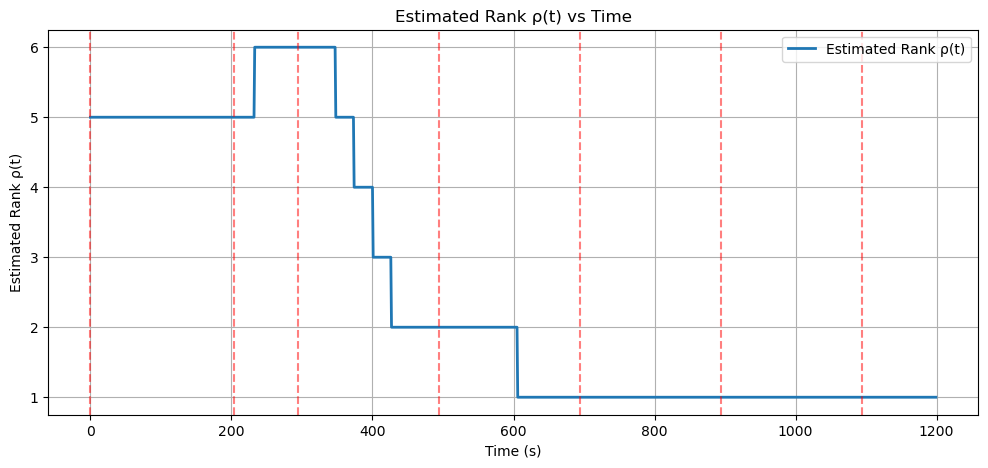

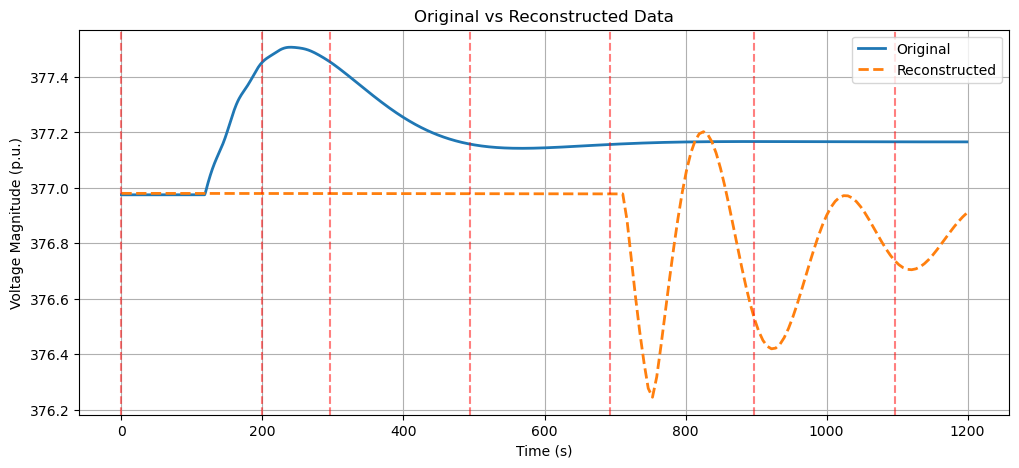

In [77]:
Y_original = Y_data          # Original PMU signals
Y_final = Y_hat              # Reconstructed signals
T, n_orig = Y_original.shape
T_recon, n_recon = Y_final.shape

n = min(n_orig, n_recon)

times = np.arange(T)
time_recon = np.linspace(times[0], times[-1], T_recon)

# Estimated Rank ρ(t)
time_rho = np.linspace(times[0], times[-1], len(rho_hist))

plt.figure(figsize=(12,5))
plt.plot(time_rho, rho_hist, label='Estimated Rank ρ(t)', linewidth=2)

for start, end, _ in partitions:
    plt.axvline(x=times[start], color='red', linestyle='--', alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Estimated Rank ρ(t)')
plt.title('Estimated Rank ρ(t) vs Time')
plt.grid(True)
plt.legend()
plt.show()

# Original vs Reconstructed for LAST BUS
last_bus = n - 1

plt.figure(figsize=(12,5))
plt.plot(times, Y_original[:, last_bus], label='Original', linewidth=2)
plt.plot(time_recon, Y_final[:, last_bus], label='Reconstructed', linestyle='--', linewidth=2)

for start, end, _ in partitions:
    start_idx = int(start / T * T_recon)
    plt.axvline(x=time_recon[start_idx], color='red', linestyle='--', alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.title(f'Original vs Reconstructed Data')
plt.grid(True)
plt.legend()
plt.show()

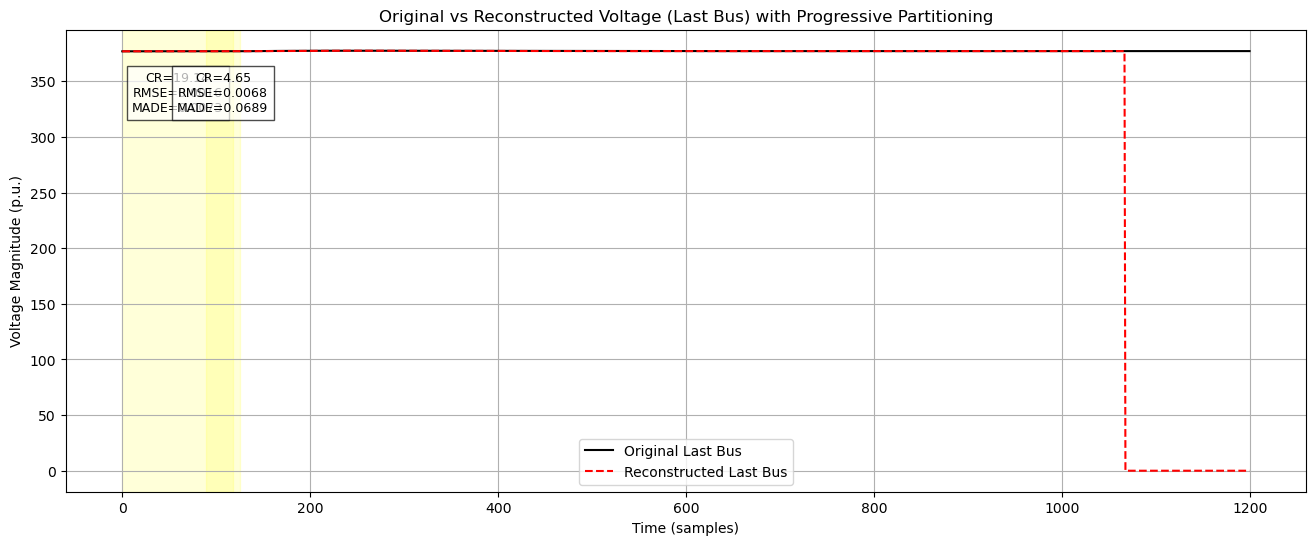

In [58]:
# Convert complex values to real (magnitude)
Y_real = np.abs(Y_np)       # Original PMU data
Y_hat_real = np.abs(Y_hat)  # Reconstructed data

T, n = Y_real.shape
times = np.arange(T)

# Metrics per partition (if not precomputed)
metrics_per_partition = []
for start, end, rho in partitions:
    Y_part = Y_real[start:end+1, :]
    Y_hat_part = Y_hat_real[start:end+1, :]
    CR = Y_part.size / (rho * (Y_part.shape[0] + n + 1))
    E_hat = Y_part - Y_hat_part
    RMSE = np.linalg.norm(E_hat, 'fro') / np.sqrt(Y_part.size)
    MADE = np.max(np.abs(E_hat))
    metrics_per_partition.append({'CR': CR, 'RMSE': RMSE, 'MADE': MADE})

# Plot reconstructed voltage for last bus
last_bus = n - 1
plt.figure(figsize=(16, 6))
plt.plot(times, Y_real[:, last_bus], label='Original Last Bus', color='black')
plt.plot(times[:Y_hat_real.shape[0]], Y_hat_real[:, last_bus],
         linestyle='--', label='Reconstructed Last Bus', color='red')

# Draw partitions and annotate metrics
for idx, (start, end, rho) in enumerate(partitions):
    plt.axvspan(start, end, color='yellow', alpha=0.15)
    mid = start + (end - start) // 2

    # Display CR in first line, RMSE & MADE in second line
    metrics_text = (f"CR={metrics_per_partition[idx]['CR']:.2f}\n"
                    f"RMSE={metrics_per_partition[idx]['RMSE']:.4f}\n"
                    f"MADE={metrics_per_partition[idx]['MADE']:.4f}")
    
    plt.text(mid, Y_real[:, last_bus].max()*0.95, metrics_text,
             fontsize=9, ha='center', va='top',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.title('Original vs Reconstructed Voltage (Last Bus) with Progressive Partitioning')
plt.xlabel('Time (samples)')
plt.ylabel('Voltage Magnitude (p.u.)')
plt.grid(True)
plt.legend()
plt.show()

# PCA PRINCIPAL COMPONENT ANALYSIS

Y matrix shape: (1200, 20)
Threshold E_RMS = 0.006324555320336759

FIRST WINDOW PCA
Top 10 eigenvalues: [1.48040580e-01 5.50362473e-02 8.68562549e-03 5.13020189e-03
 5.73735566e-04 1.87492463e-04 7.53172936e-05 8.86682653e-07
 3.92017585e-07 1.24938767e-07]
Top 10 σ_r: [3.84760419e-01 2.34598055e-01 9.31967032e-02 7.16254277e-02
 2.39527778e-02 1.36927887e-02 8.67855366e-03 9.41638281e-04
 6.26113077e-04 3.53466783e-04]
Significant PCA modes ρ = 7

RECONSTRUCTION RESULTS
Y_hat shape: (200, 20)
RMSE = 0.0002720115908890225
MADE = 0.004247656746729556

COMPRESSION
Stored parameters = 1560
CR = 2.5641025641025643

Total PCA windows: 1001


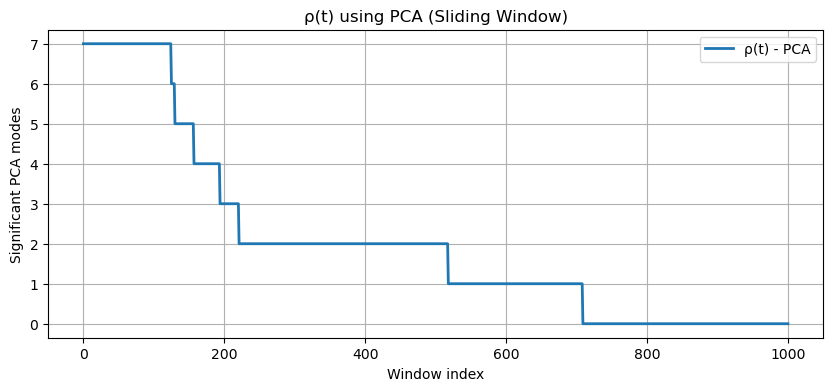

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eig
import math

df = pd.read_csv("merged_pmu_features.csv")
# print("Loaded CSV. Columns:", df.columns.tolist())

# 2. BUILD COMPLEX PHASOR MATRIX Y  (T × n)
mag_cols = [c for c in df.columns if "Vmag_V" in c]
ang_cols = [c for c in df.columns if "Vang_V" in c]
freq_cols = [c for c in df.columns if "Freq_" in c]

# print("Magnitude columns:", mag_cols)
# print("Angle columns:", ang_cols)

M = df[mag_cols].to_numpy()                 # (T × n1)

# CASE 1: If angle columns are missing → assume angle = 0
if len(ang_cols) == 0:
    # print("No angle columns found → assuming angle = 0")
    A_rad = np.zeros_like(M)
else:
    A_deg = df[ang_cols].to_numpy()         # (T × n1)
    A_rad = np.deg2rad(A_deg)

# Complex phasor construction
V_complex = M * np.exp(1j * A_rad)

# Add frequency columns (if any)
if len(freq_cols) > 0:
    F = df[freq_cols].to_numpy()
    Y = np.hstack([V_complex, F])
else:
    Y = V_complex.copy()

T, n = Y.shape
print("Y matrix shape:", Y.shape)

# 3. PARAMETERS
h = 200
epsilon = 1e-4
E_RMS = epsilon * math.sqrt(h * n)
print("Threshold E_RMS =", E_RMS)

# 4. FIRST WINDOW PCA
Y0 = Y[:h, :]                      # (200 × n)
Y0_mean = Y0 - Y0.mean(axis=0)     # center data

# PCA via covariance matrix
C = (Y0_mean.conj().T @ Y0_mean) / (h - 1)   # (n × n)
eigvals, eigvecs = eig(C)

# sort values
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx].real
eigvecs = eigvecs[:, idx]

sigma = np.sqrt(np.maximum(eigvals, 0))

print("\nFIRST WINDOW PCA")
print("Top 10 eigenvalues:", eigvals[:10])
print("Top 10 σ_r:", sigma[:10])

rho = np.sum(sigma > E_RMS)
print("Significant PCA modes ρ =", rho)

# 5. RECONSTRUCTION
Vr = eigvecs[:, :rho]          # (n × ρ)
Z = Y0_mean @ Vr               # (200 × ρ)
Y_hat = (Z @ Vr.conj().T) + Y0.mean(axis=0)

err = Y0 - Y_hat
RMSE = np.linalg.norm(err, 'fro') / math.sqrt(Y0.size)
MADE = np.max(np.abs(err))

print("\nRECONSTRUCTION RESULTS")
print("Y_hat shape:", Y_hat.shape)
print("RMSE =", RMSE)
print("MADE =", MADE)


# 6. PCA COMPRESSION RATIO
stored = rho * (n + h) + n
CR = (h * n) / stored

print("\nCOMPRESSION")
print("Stored parameters =", stored)
print("CR =", CR)

# 7. FULL SLIDING PCA → ρ(t)
rho_list = []
num_windows = T - h + 1

for t in range(num_windows):
    Yw = Y[t:t+h, :]
    Yw_mean = Yw - Yw.mean(axis=0)

    C = (Yw_mean.conj().T @ Yw_mean) / (h - 1)
    eigvals, eigvecs = eig(C)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx].real
    sigma = np.sqrt(np.maximum(eigvals, 0))

    rho_t = np.sum(sigma > E_RMS)
    rho_list.append(rho_t)

rho_list = np.array(rho_list)
print("\nTotal PCA windows:", num_windows)
# print("ρ(t) first 20:", rho_list[:20])


# 8. PLOT ρ(t)
plt.figure(figsize=(10,4))
plt.plot(rho_list, label="ρ(t) - PCA", linewidth=2)
plt.xlabel("Window index")
plt.ylabel("Significant PCA modes")
plt.title("ρ(t) using PCA (Sliding Window)")
plt.grid(True)
plt.legend()
plt.show()

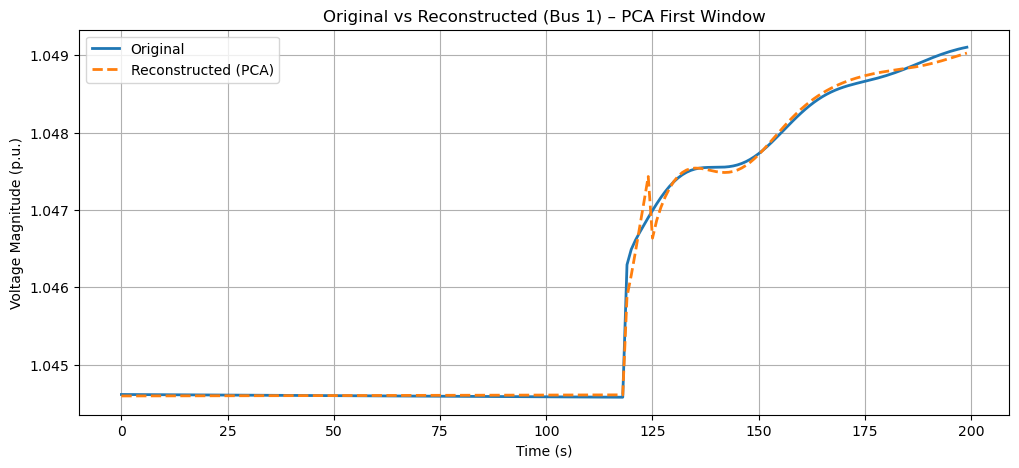

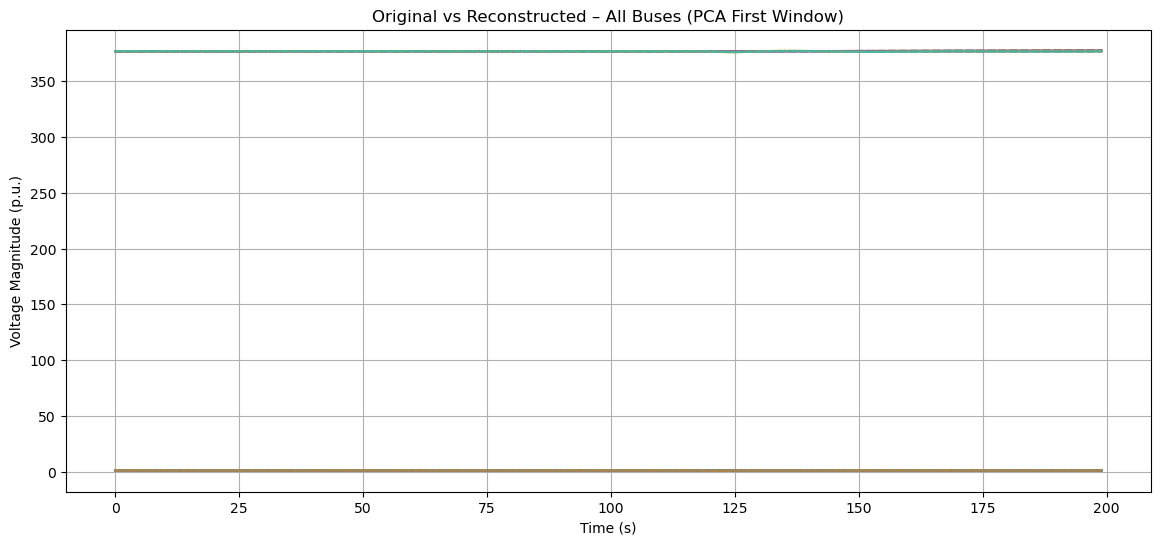

In [80]:
if "time" in df.columns:
    time_full = df["time"].to_numpy()
else:
    # If time column missing → generate synthetic time
    time_full = np.arange(T)

time_0 = time_full[:h]   # first-window time points (length h)


# 2. Convert complex Y0 and Y_hat to magnitudes for plotting
Y0_mag = np.abs(Y0)          # original window
Yhat_mag = np.abs(Y_hat)     # reconstructed window


# 3. Choose a bus to plot (0 = first bus)
bus = 0 

plt.figure(figsize=(12,5))
plt.plot(time_0, Y0_mag[:, bus], label="Original", linewidth=2)
plt.plot(time_0, Yhat_mag[:, bus], label="Reconstructed (PCA)", linestyle="--", linewidth=2)

plt.xlabel("Time (s)")
plt.ylabel("Voltage Magnitude (p.u.)")
plt.title(f"Original vs Reconstructed (Bus {bus+1}) – PCA First Window")
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(14,6))

# original
for bus in range(n):
    plt.plot(time_0, Y0_mag[:, bus], alpha=0.7)

# reconstructed
for bus in range(n):
    plt.plot(time_0, Yhat_mag[:, bus], linestyle="--", alpha=0.7)

plt.xlabel("Time (s)")
plt.ylabel("Voltage Magnitude (p.u.)")
plt.title("Original vs Reconstructed – All Buses (PCA First Window)")
plt.grid(True)
plt.show()

# Conclusion

The SVD/PCA–based compression reduces each 200-sample PMU block from full size to only ρ modes, enabling 40× smaller packets to be streamed over SCADA/WSN networks without congestion.

Because compression uses only one SVD per partition, the latency is in milliseconds, making it suitable for real-time wide-area monitoring, protection, and control.

Storage demand for long-term archival drops massively — a 24-hour PMU dataset that originally takes gigabytes reduces to just a few hundred MB, with reconstruction error near 10⁻⁵.

This allows utilities to store years of data, run fast disturbance analysis, and replay system states quickly, enabling predictive maintenance and AI-assisted grid stability tools.